<a href="https://colab.research.google.com/github/tawshiqulislam/Airline-Flight-Schedue-and-Ticket-Reservation/blob/main/BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing.text import one_hot,Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense , Flatten ,Embedding,Input,CuDNNLSTM,LSTM
from keras.models import Model
from keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATA/Just 8k - Sheet1.csv')
df.head()

,id,text,label
0,0,লিখার সময় পারলে সত্য লিখার অভ্যাস শিখুন।,negative
1,1,এটা কেন হচ্ছে? সংশ্লিষ্ট সকলের ডিপ্রেশনের ফলে?...,negative
2,2,আমাদের দেশের স্বাভাবিক অর্থনৈতিক গতিপ্রবাহকে ব...,negative
3,3,চুরি নয় লুটপাট।,negative
4,4,ইসলামী ব্যাংকের বর্তমান অবস্থা দেখে মনে হয় শাস...,neutral


In [ ]:
!pip install bnlp_toolkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 23.9 MB 1.8 MB/s 
     |████████████████████████████████| 1.2 MB 39.5 MB/s 
     |████████████████████████████████| 965 kB 47.8 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from bnlp.corpus import stopwords, punctuations
from nltk.tokenize import word_tokenize
def remove_stop_words(text):
  word_tokens = word_tokenize(text)
  words = [w for w in word_tokens if not w in stopwords]
  return " ".join(words)
def preprocessing(text):
  text_backup = text  
  text = re.sub('[%s]' % re.escape(punctuations), ' ', text)
  text = "".join(i for i in text if i in ["।"] or 2432 <= ord(i) <= 2559 or ord(i)== 32)
  text = " ".join(text.split())
  text = re.sub('\n', ' ', text)
  text = remove_stop_words(text)
  if len(text) == 0:
    text = re.sub('[%s]' % re.escape(punctuations), ' ', text_backup)
    return remove_stop_words(text)
  return text
df['text'] = df['text'].apply(lambda x : preprocessing(str(x)))

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [ ]:
df.head()

,id,text,label
0,0,লিখার সময় পারলে সত্য লিখার অভ্যাস শিখুন,negative
1,1,সংশ্লিষ্ট সকলের ডিপ্রেশনের সরকার মনোনিত পরিচাল...,negative
2,2,দেশের স্বাভাবিক অর্থনৈতিক গতিপ্রবাহকে বাধাগ্রস...,negative
3,3,চুরি লুটপাট,negative
4,4,ইসলামী ব্যাংকের বর্তমান অবস্থা শাসক জামাতের সা...,neutral


In [ ]:
sentences = []
sum = 0
for comment in df['text']:
  sents = word_tokenize(comment.strip())
  sum += len(sents)
  for sent in sents:
    cleaned_sent = preprocessing(sent)
    sentences.append(cleaned_sent.split())
print(sum)
print(len(sentences))

107272
107272


In [ ]:
import gensim
w2v_model=gensim.models.Word2Vec(sentences=sentences,vector_size=300,window=5,min_count=1)

In [ ]:
vocab = w2v_model.wv.key_to_index
vocab=list(vocab.keys())

In [ ]:
word_vec_dict={}
for word in vocab:
  word_vec_dict[word]=w2v_model.wv.get_vector(word)

In [ ]:
from keras.preprocessing.text import one_hot,Tokenizer
tok = Tokenizer()
tok.fit_on_texts(df['text'])
vocab_size = len(tok.word_index) + 1
encd_rev = tok.texts_to_sequences(df['text'])

In [ ]:
df.head()

,id,text,label
0,0,লিখার সময় পারলে সত্য লিখার অভ্যাস শিখুন,negative
1,1,সংশ্লিষ্ট সকলের ডিপ্রেশনের সরকার মনোনিত পরিচাল...,negative
2,2,দেশের স্বাভাবিক অর্থনৈতিক গতিপ্রবাহকে বাধাগ্রস...,negative
3,3,চুরি লুটপাট,negative
4,4,ইসলামী ব্যাংকের বর্তমান অবস্থা শাসক জামাতের সা...,neutral


In [ ]:
df['label']=df['label'].replace({'positive':1,'negative':0,'neutral':2})
df.head()

,id,text,label
0,0,লিখার সময় পারলে সত্য লিখার অভ্যাস শিখুন,0
1,1,সংশ্লিষ্ট সকলের ডিপ্রেশনের সরকার মনোনিত পরিচাল...,0
2,2,দেশের স্বাভাবিক অর্থনৈতিক গতিপ্রবাহকে বাধাগ্রস...,0
3,3,চুরি লুটপাট,0
4,4,ইসলামী ব্যাংকের বর্তমান অবস্থা শাসক জামাতের সা...,2


In [ ]:
maxi = -1
for i,rev in enumerate(df['text']):
  tokens=rev.split()
  if (len(tokens) > maxi):
    maxi = len(tokens)

In [ ]:
tok = Tokenizer()
tok.fit_on_texts(df['text'])
vocab_size = len(tok.word_index) + 1
encd_rev = tok.texts_to_sequences(df['text'])

In [ ]:
max_rev_len = maxi + 1
vocab_size = len(tok.word_index) + 1
embed_dim=300

In [ ]:
pad_rev= pad_sequences(encd_rev, maxlen=max_rev_len, padding='post')
pad_rev.shape

(8066, 77)

In [ ]:
embed_matrix=np.zeros(shape=(vocab_size,embed_dim))
for word,i in tok.word_index.items():
  embed_vector=word_vec_dict.get(word)
  if embed_vector is not None:
    embed_matrix[i]=embed_vector

In [ ]:
Y = to_categorical(df['label'])
x_train,x_test,y_train,y_test=train_test_split(pad_rev,Y,test_size=0.20,random_state=42)

In [ ]:
classes = len(df['label'].value_counts()) #number of labels

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from sklearn.model_selection import train_test_split
from keras.initializers import Constant
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

embedding_vector_features=40
model=Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=max_rev_len,embeddings_initializer=Constant(embed_matrix)))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.5))
model.add(Dense(32))
model.add(Dropout(0.3))
model.add(Dense(3, activation='sigmoid'))
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 77, 300)           4856700   
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              320800    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                6432      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                      

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
101/101 [==============================] - 51s 465ms/step - loss: 0.9442 - accuracy: 0.5412 - val_loss: 0.7150 - val_accuracy: 0.6884
Epoch 2/10
101/101 [==============================] - 46s 460ms/step - loss: 0.3390 - accuracy: 0.8856 - val_loss: 0.6126 - val_accuracy: 0.7819
Epoch 3/10
101/101 [==============================] - 46s 459ms/step - loss: 0.1071 - accuracy: 0.9695 - val_loss: 0.7700 - val_accuracy: 0.7980
Epoch 4/10
101/101 [==============================] - 47s 461ms/step - loss: 0.0661 - accuracy: 0.9834 - val_loss: 0.8295 - val_accuracy: 0.7881
Epoch 5/10
101/101 [==============================] - 46s 460ms/step - loss: 0.0459 - accuracy: 0.9910 - val_loss: 0.8685 - val_accuracy: 0.7962
Epoch 6/10
101/101 [==============================] - 46s 460ms/step - loss: 0.0389 - accuracy: 0.9910 - val_loss: 0.8980 - val_accuracy: 0.8036
Epoch 7/10
101/101 [==============================] - 46s 456ms/step - loss: 0.0360 - accuracy: 0.9916 - val_loss: 0.9086 - val_ac

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("BiLSTM accuracy = ",scores[1]*100)

BiLSTM accuracy =  80.17348051071167


In [ ]:
prediction= (model.predict(x_test))
prediction

array([[0.9965305 , 0.03168666, 0.22147453],
       [0.98464614, 0.1121197 , 0.19160903],
       [0.03913525, 0.2845326 , 0.9677074 ],
       ...,
       [0.09564081, 0.96470755, 0.2710923 ],
       [0.02185276, 0.9986807 , 0.05583617],
       [0.09929803, 0.9972869 , 0.0260253 ]], dtype=float32)

In [ ]:
test=np.argmax(y_test,axis=1)
pred=np.argmax(prediction,axis=1)

In [ ]:
from sklearn import datasets
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
 

 
from sklearn.metrics import classification_report

print(classification_report(test,pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       665
           1       0.76      0.84      0.80       547
           2       0.73      0.66      0.69       402

    accuracy                           0.80      1614
   macro avg       0.79      0.78      0.79      1614
weighted avg       0.80      0.80      0.80      1614



In [ ]:
import sklearn
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
print(metrics.confusion_matrix(test,pred))

[[572  48  45]
 [ 36 458  53]
 [ 42  96 264]]


In [ ]:
class_names=['Negative','Positive', 'Neutral']

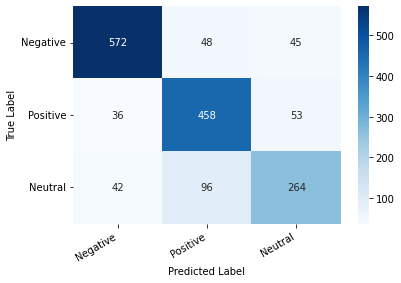

In [ ]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label');
cm = confusion_matrix(test, pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)